<a href="https://colab.research.google.com/github/PedroDS4/Convolucao_Circular/blob/main/Convolucao_Linear_e_Circular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Convolução linear discreta para sinais digitais**
A convolução linear é uma operação entre dois sinais ou funções que representa a saída de um sistema linear e invariante no tempo.
A convolução linear discreta entre dois sinais $x[n]$ e $h[n]$ é dada por


$$
y[n] = x[n] * h[n] = ∑_{k = -∞}^{∞} x[k] \cdot h[n-k]
$$


#**Convolução Circular**
A convolução circular é a convolução entre dois sinais que tiveram seus espectros amostrados, e então por esse fato se tornaram sinais periódicos, dessa maneira, é possível construir uma matriz de convolução circular que se aproveite desse fato para o cálculo desse tipo de convolução, que pode ser considerada igual a convolução linear caso o tamanho da convolução seja suficientemente grande.
A convolução circular entre dois sinais de tempo discreto é dada por

$$
y[n] = x[n] \circledast h[n] = ∑_{0}^{N-1} x[k] \cdot h[n-k]
$$

Sejam os suportes dos sinais $x$ e $h$ dados por

$$
sup_{x[n]} =[0,M-1]
$$

e

$$
sup_{h[n]} =[0,L-1]
$$

então para que não haja sobreposição na convolução circular, e ela se iguale a linear, é necessário que

se $N \geq M + L -1$ , a convolução circular se torna igual à linear.


#**Convolução Circular Matricial**
A operação de convolução pode ser ainda escrita no formato matricial, mostrando mais uma vez que a convolução é uma operação linear, e então temos

$$
y = Hx
$$

onde H é uma matriz de toeplitz do sinal $h[n]$, ou seja, é construída de modo que cada coluna seja um deslocamento circular do vetor que representa o sinal $h[n]$, que tem a forma:


$$
H = \begin{bmatrix}
h[0] & h[N-1] & h[N-2] & \cdots & h[1] \\
h[1] & h[0] & h[N-1] & \cdots & h[2] \\
h[2] & h[1] & h[0] & \cdots & h[3] \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
h[N-1] & h[N-2] & h[N-3] & \cdots & h[0]
\end{bmatrix}
$$

mais uam vez, se $N \geq L+M-1$, essa operação matricial implementa a convolução linear exata.

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import time
#Seed
np.random.seed(0)

# Funções de Plotagem
def plot_completo(nome_x, nome_y, nome_grafico, cor, vetor_y, vetor_x = None):
    fig, ax = plt.subplots()
    ax.set(xlabel=nome_x, ylabel=nome_y, title=nome_grafico)
    if vetor_x is None:
        ax.plot(vetor_y,cor)
    else:
        ax.plot(vetor_x, vetor_y, cor)


    ax.grid()

def stem_completo(nome_x, nome_y, nome_grafico, cor, vetor_y, vetor_x = None):
    fig, ax = plt.subplots()
    ax.set(xlabel=nome_x, ylabel=nome_y, title=nome_grafico)
    if vetor_x is None:
        ax.stem(vetor_y,cor)
    else:
        ax.stem(vetor_x, vetor_y, cor)

    ax.grid()



def null_pad(x, N_0):
    N = len(x);
    y = np.zeros(int(N_0));
    for i in range(0,int(N_0)):
       if(i<N):
            y[i] = x[i];
       else:
            y[i] = 0;

    return y


def anull_pad(x):
    N = len(x)
    j = 0
    for i in range(N - 1, -1, -1):
        if x[i] != 0.0:
            return x[:N - j]
        else:
            j = j + 1
    return x[:N - j]



#Geração dos dados sísmicos
def gerar_reletividade_aleatoria(M,s):
  #M: número de amostras da refletividade
  #s: Espaçamento entre as amostras não nulas
  #A função np.random.binomial corrige o fato dos impulsos da refletividade ficarem igualmente espaçados
  refletividade = np.zeros(M)
  for i in range(5,M-5,s):
    refletividade[i] = (np.random.uniform(-1,1))*np.random.binomial(1,0.8)

  return refletividade



def ricker_wavelet(f0, t):
  #f0: Frequência central da wavelet de ricker
  #t: eixo temporal que a wavelet é calculada
  ricker_wavelet = (1 - 2 * (np.pi**2) * (f0**2) * (t**2)) * np.exp(-(np.pi**2) * (f0**2) * (t**2))

  return ricker_wavelet






def conv_matrix(ww, NN, DD = None):
    """
    Gera uma matriz de convolução a partir de um vetor de pesos.
    A função cria uma matriz onde cada coluna é uma versão deslocada do vetor de
    pesos, permitindo realizar operações de convolução em um sinal.
    Parâmetros:
    ----------
    ww : array-like
        Um vetor unidimensional de pesos ou coeficientes a serem usados na
        convolução.
    NN : int
        O número de colunas desejadas na matriz de convolução, que geralmente
         corresponde à largura da janela de convolução.
    DD : int, opcional
        A profundidade da matriz de convolução. Se não for fornecida, assume-se
        que DD é igual a NN. Se DD for maior que o comprimento de ww, o vetor
        será preenchido com zeros na parte inferior.
    Retorna:
    --------
    HH : ndarray
        Uma matriz 2D (DD, NN) onde cada coluna é o vetor de pesos 'ww'
        deslocado por uma quantidade específica. O tamanho da matriz é definido
         por DD e NN.
    Exemplo:
    --------
        ww = np.array([1, 2, 3])
        NN = 9
        DD = 11
        result = conv_matrix(ww, NN, DD)
        print(result)
        [[1. 0. 0. 0. 0. 0. 0. 0. 0.]
        [2. 1. 0. 0. 0. 0. 0. 0. 0.]
        [3. 2. 1. 0. 0. 0. 0. 0. 0.]
        [0. 3. 2. 1. 0. 0. 0. 0. 0.]
        [0. 0. 3. 2. 1. 0. 0. 0. 0.]
        [0. 0. 0. 3. 2. 1. 0. 0. 0.]
        [0. 0. 0. 0. 3. 2. 1. 0. 0.]
        [0. 0. 0. 0. 0. 3. 2. 1. 0.]
        [0. 0. 0. 0. 0. 0. 3. 2. 1.]
        [0. 0. 0. 0. 0. 0. 0. 3. 2.]
        [0. 0. 0. 0. 0. 0. 0. 0. 3.]]
    """
    MM = len(ww)


    aux_shift = (MM//2)
    if DD is None:
        DD = NN

    elif DD == MM+NN-1:
        aux_shift = 0

    elif MM > NN:
        aux_shift = (NN//2)

    ww_pad = np.pad(ww, (0, DD + MM), 'constant')

    HH = np.zeros((DD, NN), dtype = ww.dtype)

    for nn in range(NN):
         aux_vect = np.roll(ww_pad, nn-aux_shift)
         HH[:, nn] = aux_vect[:DD]

    return HH



def matricial_conv(signal_1,signal_2):
    """
    Parâmetros:
    signal_1: Um dos sinais que será usado na convolução
    signal_2: O outro sinal que será usado na convolução



    returna: O resultado da convolução linear
    """


    M = len(signal_1)
    L = len(signal_2)
    N_0 = M+L-1

    signal_1_pad = null_pad(signal_1,N_0)
    signal_2_pad = null_pad(signal_2,N_0)

    H = np.zeros((N_0,N_0))

    for k in range(N_0):
      H[:,k] = np.roll(signal_1_pad, shift=k)


    return H@signal_2_pad



def circular_conv(x1,x2,N_0):

    N = len(x1)
    M = len(x2)

    x11 = null_pad(x1,N_0)
    x22 = null_pad(x2,N_0)

    X10 = np.zeros((N_0,N_0))

    for k in range(N_0):
      X10[:,k] = np.roll(x11, shift=k)

    return X10@x22


##**Ambiente de Simulação**

Tempo de execução np.convolve: 0.0001442432403564453
Tempo de execução circular_conv: 0.011677980422973633


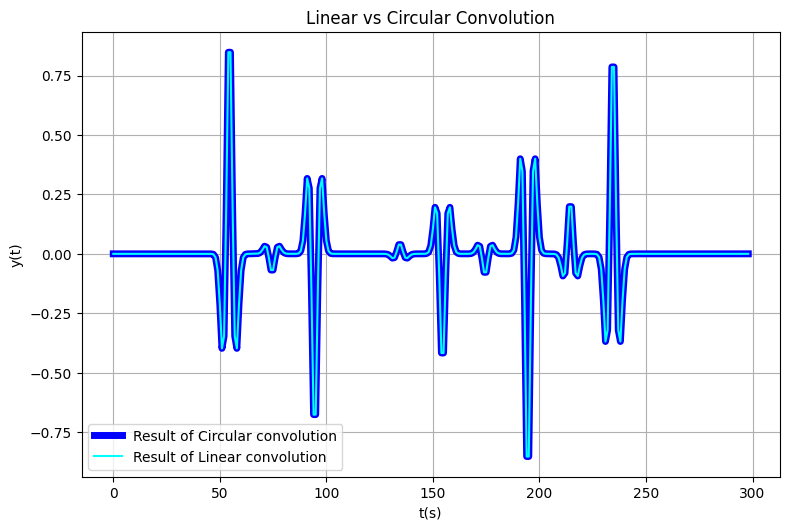

In [37]:
# Parâmetros
t = np.linspace(-0.25,0.25,100)

# Gerar a wavelet de Ricker
f0 = 25  # Frequência central da wavelet de Ricker
w = ricker_wavelet(f0,t)

dt = (t[-1] - t[0])/len(t)


# Gerar a resposta impulsiva
M = int(1/dt)
s = int(M/10)

r = gerar_reletividade_aleatoria(M,s)




start_time = time.time()
x2 = np.convolve(w, r, 'full')
end_time = time.time()
time_np_convolve = end_time - start_time



start_time = time.time()
x1 = matricial_conv(w, r)
end_time = time.time()
time_circular_conv = end_time - start_time


N = len(x1)

t_x = np.arange(0,N)*dt




print(f"Tempo de execução np.convolve: {time_np_convolve}")
print(f"Tempo de execução circular_conv: {time_circular_conv}")


#x2 = anull_pad(x2)

largura = 8
altura = 10

#Plotando refletividade e refletividade estimada
fig = plt.figure(figsize=(largura, altura))
plt.subplot(2, 1, 1)  # 1 linha, 2 colunas, 1º gráfico
plt.plot( x1, label='Result of Circular convolution', color="blue",linewidth = 5)
plt.plot( x2, label=f'Result of Linear convolution', color = 'cyan')
plt.xlabel('t(s)')
plt.ylabel('y(t)')


plt.grid()
plt.legend()

plt.title('Linear vs Circular Convolution')

# Ajuste para layout
plt.tight_layout()

# Exibindo os gráficos
plt.show()
